# Introduction to deep learning with TensorFlow

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work, using the **moodle platform**.
- This means that **each student in the pair sends the same file**

# Gentle reminder: no evaluation if you don't respect this EXACTLY

## To generate the name of your file, use the following

In [18]:
# Change here using your first and last names
fn1 = "Van-Huy"
ln1 = "Vo"
fn2 = "Ta-Duy"
ln2 = "Nguyen"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_vo_van-huy_and_nguyen_ta-duy.ipynb


# Table of content

[0. Tensorflow basics](#basics)<br>
[1. Handwritten digit recognition with MNIST](#mnist)<br>
[2. A first model: softmax (or multinomial logistic) regression](#softmax)<br>
[3. Feed-Forward Neural Network (FFNN)](#ffnn)<br>
[4. Convolutional Neural Network](#cnn)<br>
[5. Hand-made feed-forward network for the XOR problem](#xor)<br>

In [20]:
from __future__ import print_function
from six.moves import cPickle as pickle
from six.moves import range

import numpy as np
from scipy.optimize import check_grad

import tensorflow as tf

%matplotlib inline

print("tensorflow version %s (should be at least 0.12.1)" % tf.__version__)

tensorflow version 1.0.0 (should be at least 0.12.1)


<a id='basics'></a>
# 0. Tensorflow basics

The `numpy` library does some expensive operations outside Python using efficient code (Fortran, C/C++). However, switching back to python after each operation cause a big overhead because of unnecessary copies of the data. 

The library `tensorflow` does all the computations outside of Python: the python API is used to define a graph of operations, that will run entirely using C++ binaries. This architecture allows to get rid of the overhead. Besides, knowing the computational graph beforehand allows to parallelize and/or distribute the computation more easily. As a result, `tensoflow` can run the computations on multiple CPUs or GPUs, and on multiple servers.


## 0.1. Operations on tensors

Graphs of operations contains descriptions of symbolic variables, such as:

In [21]:
## Constant tensors
x1 = tf.ones((2, 3), dtype=tf.float32)
x2 = tf.constant(np.array([0, 1, 2]), shape=(3, 1), dtype=tf.float32)

# equivalently
x3 = tf.range(0, 3, 1, tf.float32)
x4 = tf.fill((1, 3), 2)

with tf.Session() as sess:
    print("x1: \n", sess.run(x1))
    print("x2: \n", sess.run(x2))
    print("x3: \n", sess.run(x3))
    print("x4: \n", sess.run(x4))

x1: 
 [[ 1.  1.  1.]
 [ 1.  1.  1.]]
x2: 
 [[ 0.]
 [ 1.]
 [ 2.]]
x3: 
 [ 0.  1.  2.]
x4: 
 [[2 2 2]]


In [22]:
## random tensors
norm = tf.random_normal([1, 3], mean=0, stddev=2)

# each time random tensors are run, new samples are generated
with tf.Session() as sess:
    print("run 1: \n", sess.run(norm))
    print("run 2: \n", sess.run(norm))

run 1: 
 [[ 0.59807539  4.43660021  5.1217885 ]]
run 2: 
 [[ 0.06563938 -0.74832672 -0.66785991]]


In [23]:
# You can seed a random tensor to generate a repeatable sequence
seeded_norm = tf.random_normal([1, 3], seed=1234)

with tf.Session() as sess:
    print("First session")
    print("run 1, seeded: \n", sess.run(seeded_norm))
    print("run 2, seeded: \n", sess.run(seeded_norm))
print("\n")

with tf.Session() as sess:
    print("Second session")
    print("run 1, seeded: \n", sess.run(seeded_norm))
    print("run 2, seeded: \n", sess.run(seeded_norm))

First session
run 1, seeded: 
 [[ 0.51340485 -0.25581399  0.65199131]]
run 2, seeded: 
 [[ 1.31229651 -0.81987709 -0.71966368]]


Second session
run 1, seeded: 
 [[ 0.51340485 -0.25581399  0.65199131]]
run 2, seeded: 
 [[ 1.31229651 -0.81987709 -0.71966368]]


## 0.2. Input data
To represent input data in the computation graph, we use `placeholders`. Placeholders are tensors that will be fed with data when running the session, e.g.:

In [25]:
# Placeholders example
x = tf.placeholder(tf.float32, shape=(2, 2)) # 2 x 2 tensor
y = tf.matmul(x, x) # dot product

In [ ]:
## ERROR: will fail since x was not fed (uncomment, run the code below and look at 
##        the very long error message)
#with tf.Session() as sess:
#    print(sess.run(y))

In the example below, we run the computation by feeding the contents of `rand_array` into placeholder `x`.
Now the code works

In [26]:
with tf.Session() as sess:
    rand_array = np.random.rand(2, 2)
    print("random 2x2 array: \n", rand_array)
    print("Numpy implementation: \n", rand_array.dot(rand_array))
    print("TensorFlow implementation: \n", sess.run(y, feed_dict={x: rand_array})) # Will succeed.

random 2x2 array: 
 [[ 0.64610341  0.70250021]
 [ 0.39860759  0.88679977]]
Numpy implementation: 
 [[ 0.69747153  1.0768648 ]
 [ 0.61102684  1.06643575]]
TensorFlow implementation: 
 [[ 0.6974715   1.07686472]
 [ 0.61102682  1.06643569]]


## 0.3. Variables

`Variables` are in-memory buffers containing tensors, i.e. they are used to save parameters used during computations: they will contain for instance the model weights of a neural network during its training. 
They maintain their state in the computation graph accross calls to `run()`, namely the contents of `variable` remain the same between different runs.

In the example below we initialize a variable with a tensor

In [27]:
# Variables must be explicitely initialized.
# The initial value can be a tensor of any type or shape
# Note that the default type is always float32.
foo = tf.Variable(tf.zeros([3]))

# Random tensors can be used to initialize variables
var = tf.Variable(tf.random_normal((2, 3)))

# Variable initializers must be run explicitly before 
# other ops in your model can be run
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print("Variable initialized with a constant tensor: \n", sess.run(foo))
    print("Variable initialized with a random tensor: \n", sess.run(var))

Variable initialized with a constant tensor: 
 [ 0.  0.  0.]
Variable initialized with a random tensor: 
 [[ 1.47003138  0.3270638  -0.18905835]
 [ 1.22427285 -0.40053752  0.87136829]]


In the example below, we use a `n_runs` variable which is incremented at each run. 
Note that it's **state is maintained between runs**.

In [28]:
n_runs = tf.Variable(0)
one = tf.constant(1)
increment_n_runs = tf.assign_add(n_runs, one)
# Remark: a more direct tf.assign_add(n_runs, 1) works also, but
#         this allows to illustrate the use of tf.constant

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print("Variable maintain their state across runs")
    print("Run #1: ", sess.run(increment_n_runs))
    print("Run #2: ", sess.run(increment_n_runs))
    print("Run #3: ", sess.run(increment_n_runs))

Variable maintain their state across runs
Run #1:  1
Run #2:  2
Run #3:  3


In [29]:
# Variables can be saved to disk during and after some computations and 
# restored later. This is particularly useful to save the weights of a 
# trained model.

# A saver operation is required to save and restore all the variables.
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    # Save the variables to disk.
    print("Saved variable: \n", sess.run(var))
    save_path = saver.save(sess, "/tmp/model.ckpt")
    print("Model saved in file: %s" % save_path)

print("\n")
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/model.ckpt")
    print("Model restored.")
    print("Restored variable: \n", sess.run(var))

Saved variable: 
 [[ 0.22532335  0.12170933 -0.51565683]
 [ 0.04100075  1.59555888 -0.30819646]]
Model saved in file: /tmp/model.ckpt


Model restored.
Restored variable: 
 [[ 0.22532335  0.12170933 -0.51565683]
 [ 0.04100075  1.59555888 -0.30819646]]


## 0.4 Running the computations

In a nutshell, `TensorFlow` works like this:

* Declare a computation graph in which you define what are the inputs (`Placeholder`s), the `Variable`s, and the `Operation`s you want to perform with them.

      with graph.as_default():
          x = tf.placeholder(...)
          W = tf.Variable(...)
          ...

* You can then run the `Operation`s on this graph as many times as you want by calling `session.run()`. A `Session` object encapsulate the environment in which `Operation` objects are executed, and `Tensor`s evaluated.

      with tf.Session(graph=graph) as session:
          session.run(fetches, feed_dict=...)
          ...
      
The `fetches` argument may be a single graph element, or an arbitrarily nested `list`, `tuple`, `namedtuple`, or `dict` containing graph elements at its leaves. A graph element can be one of the following types:

- An `Operation`, e.g. "run an optimizer step". The corresponding fetched value will be None.
- A `Tensor` (cf. examples above). The corresponding fetched value will be a numpy ndarray containing the value of that tensor.
- and other options out of this tutorial's scope

A session may own resources, such as variables, queues, and readers. 
It is important to release these resources when they are no longer required. 
To do this, either invoke the `close()` method on the session, or use the session as a context manager. 
The following two examples are equivalent:

    # Using the `close()` method.
    sess = tf.Session()
    sess.run(...)
    sess.close()

    # Using the context manager.
    with tf.Session() as sess:
        sess.run(...)
      
### Remark

You may have noted that the tensors declared earlier were not declared explicitely as being part of a graph. 
In fact, when you don't specify a graph when declaring tensors or initializing sessions, TensorFlow will use a "default" graph. When working on different models, using only the default graph might be messy. 
In the following, we will declare each model in a specific graph:

    some_model_graph = tf.Graph()

    with some_model_graph.as_default():
        # Declare all your tensors and operations here
        # ...
        
    with tf.Session(graph=some_model_graph) as sess:
        # Run some stuff
        sess.run(...)

Beware though, different graphs are not different namespaces, i.e. if you declare a tensor `foo` in a graph `g1` and then declare an other tensor `foo` in a graph `g2`, you might have some trouble. 
The internals of TensorFlow are out of the scope of this tutorial, but you can find more details in TensorFlow [documentation](https://www.tensorflow.org/api_docs/python/framework/).

<a id='mnist'></a>
# 1. Handwritten digit recognition with MNIST

For the first part of this tutorial, we will use the [MNIST](http://yann.lecun.com/exdb/mnist) dataset.
This dataset contains images representing handwritten digits. 
Each image is 28 x 28 pixels, and each pixel is represented by a number (gray level). 
These arrays can be flattened into vectors of 28 x 28 = 784 numbers.
You can then see each image as a point in a 784-dimensional vector space. 
You can find interesting visualisations of this vector space [http://colah.github.io/posts/2014-10-Visualizing-MNIST/](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) (but don't spend too much time looking at the cool graphs :))

## 1.1. Introduction

The labels in $\{0, 1, 2, \ldots, 9\}$ giving the digit on the image are be represented using one-hot encoding: labels in $\{0, 1, 2, \ldots, 9\}$ are replaced by labels in $\{ 0, 1\}^{10}$, namely $0$ is replaced by $(1, 0, \ldots 0)$, $1$ is replaced by $(0, 1, 0, \ldots 0)$, $2$ is replaced by $(0, 0, 1, 0, \ldots, 0)$, etc.

MNIST data is **already normalized** to avoid numerical instability.
Indeed, working with big floats can lead to important numerical errors. 
It is a good practice to normalize the inputs (features) so that they have zero mean and a constant (small) variance. To convince yourself of the damages that can result from numerical instability, see the following cell:

In [30]:
foo = 1e9
for i in range(int(1e6)):
    foo += 1e-6
foo -= 1e9
print("Numerically instable sum: %f " % foo)

bar = 1
for i in range(int(1e6)):
    bar += 1e-6
bar -= 1
print("Numerically stable sum: %f " % bar)

Numerically instable sum: 0.953674 
Numerically stable sum: 1.000000 


## 1.2. Download the data

In [31]:
from tensorflow.examples.tutorials.mnist import input_data

# Download the data in the working directory
mnist = input_data.read_data_sets("./mnist/", one_hot=True)

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


In [32]:
# Datasets are convenient classes you can use to store data
# when using TensorFlow. You can also use numpy.ndarrays as easily.
type(mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [33]:
# Structure of the dataset object
print([elem for elem in dir(mnist) if not elem.startswith('_')])

['count', 'index', 'test', 'train', 'validation']


In [34]:
print("Number of training examples: ", mnist.train.images.shape[0])
print("Number of validation examples: ", mnist.validation.images.shape[0])
print("Number of test examples: ", mnist.test.images.shape[0])
print("Images dimensions: ", mnist.test.images.shape[1], "(i.e 28 x 28)")
print("Number of classes: ", mnist.test.labels.shape[1])

Number of training examples:  55000
Number of validation examples:  5000
Number of test examples:  10000
Images dimensions:  784 (i.e 28 x 28)
Number of classes:  10


## 1.3. A first look at the data

In the next cell we illustrate the first for elements of the training data: 
pixels grayscale of the digit and their corresponding label.

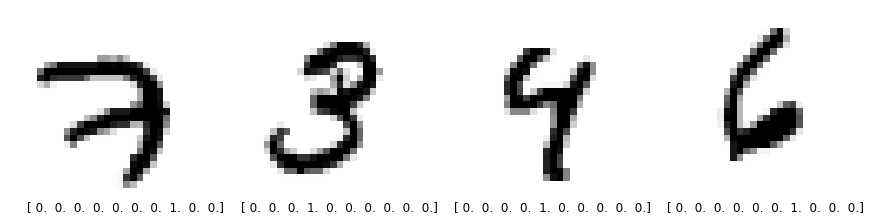

In [35]:
plt.figure(figsize=(12, 3))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(mnist.train.images[i].reshape(28, 28), 
               interpolation="none", cmap="gray_r")
    plt.text(0, 30, str(mnist.train.labels[i]), fontsize=12)
    plt.axis("off")
plt.tight_layout()

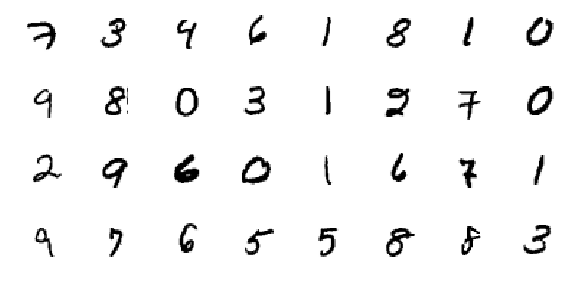

In [36]:
plt.figure(figsize=(8, 4))
n_rows = 4
n_cols = 8

for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(mnist.train.images[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.axis("off")
plt.tight_layout()
plt.show()

The first character is a 7 digit, encoded in grayscale matrix as follows (note that we multiply again by 255):

In [37]:
print(np.array2string((255 * mnist.train.images[0]).astype(np.int).reshape(28, 28), 
                      max_line_width=150))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  97  96  77 118  61   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  90 138 235 235 235 235 235 235 251 251 248 254 245 235 190  21   

<a id='softmax'></a>
# 2. A first model: softmax (or multinomial logistic) regression 

## 2.1. Description of the model

We want to classify these pictures to predict the digit $k$ they represent for $k \in \{0, \ldots, 9\}$.
A simple model allowing to do that is softmax regression.

The idea behind this model is to produce a score for each input image $x$ using a simple linear model. 
To do so, we assume that belonging to a class $k$ (corresponding to digit $k$) can be expressed by a weigthed sum of the pixel intensities, with weights $W_{k, 1}, \ldots, W_{k, 784}$ and to a bias $b_k$ capturing variability independent of the input:
$$
\text{score}_k(x_i) = \sum_{j=1}^{784} W_{k, j} x_j + b_k,
$$
These scores are sometimes called the "logits" in the deep learning community.
We then use the softmax function to convert the scores into predicted probabilities $p_k$:
$$
p_k(x_i) = \text{softmax}(\text{score}_k(x_i)) = \frac{\exp(\text{score}_k(x_i))}{\sum_{k'=1}^{10}\exp(\text{score}_{k'}(x_i))}
$$
for $k=1, \ldots, 10$.

## QUESTION

1. As an exercise, implement the softmax function below. Beware of the overflow!

In [ ]:
def softmax(x):
    # Remark: this function shouldn't be used as part of TensorFlow operations.
    #         It is just a warming initial exercice, independent of the remaining.
    ## TODO

    ## END TODO

test_input = np.array([1, .5, 0.1])
print(softmax(test_input))

The plot in the next cell illustrates the effect of the softmax on an input

In [ ]:
test_input = np.array([1, .5, 0.1])
x = np.linspace(0, 5)
y = np.array([softmax(test_input * i) for i in x])
plt.figure()
ax = plt.gca()
ax.plot(x, y[:, 0], label="1")
ax.plot(x, y[:, 1], label="0.5")
ax.plot(x, y[:, 2], label="0.1")
plt.xlabel("multiplicative factor of the scores")
plt.ylabel("softmax")
plt.legend(loc="best")
plt.show()

## 2.2. The computational graph for training of softmax regression

To train the model weights $W_{k, j}$ and $b_k$ for $k=1, \ldots, 10$ and $j=1, \ldots, 784$, we consider the goodness-of-fit given by the negative log-likelihood.
For the considered model, the negative log-likelihood of a sample with input $x_i \in \mathbb R^{784}$ and label $y_i \in \{0, 1\}^{10}$, it is given by the cross-entropy between the scores $p_k(x_i)$ and the label $y_i$:
$$
- \sum_{k=1}^{10} y_{i, k} \log(p_k(x_i))
$$
For this first model, we will simply use stochastic gradient descent over small batches of data. It can be done easily with TensorFlow, as it will automatically and efficiently compute the gradient from your graph, then apply an optimization algorithm of your choice to perform the parameters update.

In [ ]:
softmax_regression_graph = tf.Graph()

with softmax_regression_graph.as_default():
    # Create a placeholder of dimension `[None, 784]`, containing float32
    # `None` means that the first dimension can be of any length
    # This placeholder will be fed with MNIST images
    image =  # TODO
    
    # Create a placeholder of dimension `[None, 10]`, containing float32
    # to be fed with the labels
    label =  # TODO

    # Declare model parameters, ie. a tensor containing weights
    # of dimension `[784, 10]` and a tensor containing the bias
    # parameters of dimension `[10]`.
    # Initialise these tensors with zeros
    W =  # TODO
    b =  # TODO

    # Now declare the model described above
    # you can use tf.matmul(foo, bar) to perform 
    # matrix multiplication on 2D tensors
    # and tf.nn.softmax(baz) to compute the softmax of a tensor
    scores =  # TODO
    predicted_probabilities =  # TODO
 
    # The raw formulation of cross-entropy,
    #
    #   tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.nn.softmax(y)),
    #                                 reduction_indices=[1]))
    #
    # can be numerically unstable.
    #
    # So here, use tf.nn.softmax_cross_entropy_with_logits on the raw
    # outputs of 'scores', and then average across the batch using tf.reduce_mean
    loss =  # TODO
    
    # Optimization step
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Test trained model
    correct_prediction = tf.equal(tf.argmax(predicted_probabilities, 1), tf.argmax(label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## 2.3. Launching of the training

In [ ]:
# Size of the mini-batch
mini_batch_size = 100
# Number of SGD steps
n_steps = 1000

training_data = {image: mnist.train.images, label: mnist.train.labels}
validation_data = {image: mnist.validation.images, label: mnist.validation.labels}
test_data = {image: mnist.test.images, label: mnist.test.labels}

with tf.Session(graph=softmax_regression_graph) as sess:
    tf.global_variables_initializer().run()
    # Training loop
    for step in range(n_steps + 1):
        # Get next mini-batch
        batch_images, batch_labels = mnist.train.next_batch(mini_batch_size)
        feed = {image: batch_images, label: batch_labels}
        _, current_loss = sess.run([train_step, loss], feed_dict=feed)        
        if step % 200 == 0:
            print('Step %d' % step)
            print('....Loss:     %f' % current_loss)
            print('....Accuracy on train: %f' % sess.run(accuracy, feed_dict=training_data))
            print('....Accuracy on validation: %f' % sess.run(accuracy, feed_dict=validation_data))
    print('Accuracy on test: %f' % sess.run(accuracy, feed_dict=test_data))
    # Save the weights into a numpy ndarray for plotting
    weights = sess.run(W)

## 2.4. Visualization of the model-weights

In [ ]:
imgs = weights.reshape(28, 28, 10)

F = plt.figure(1, (8, 4))
from mpl_toolkits.axes_grid1 import ImageGrid
grid = ImageGrid(F, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),
                 axes_pad=0.5,
                 add_all=True,
                 label_mode="L",
                 cbar_mode="single")

vmin, vmax = imgs.min(), imgs.max()
for i in range(10):
    ax = grid[i]
    im = imgs[:,:,i]
    mappable = ax.imshow(im, interpolation="nearest", vmin=vmin, vmax=vmax, cmap="bwr")
    ax.axis("off")
    ax.set_title("%i" % i)
grid.cbar_axes[0].colorbar(mappable, ticks=[vmin, 0, vmax])
plt.show()

## 2.5. Some remarks

You should have reached an accuracy of around 0.9 with this simple model. 
**Too easy**! You almost solved the problem using a simple softmax regression. 
Weight matrices plots show that the learned weights are consistant with the digits they should predict. 
You should be able to see rough shapes corresponding to the digits 0, 1, 2, 3, etc.

MNIST is a very very **clean** dataset. Digits are rescaled, smoothed, centered, and pixel values are normalized beforehand. Let's switch to a slightly harder dataset: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

This time, labels are letters from 'A' to 'J' (10 classes). 
These letters are taken from digital fonts instead of handwriting pictures. 
We will use a reduced amount of data to ensure a reasonable training time. 
The training set you will use has 200k labelled examples, while the validation and test sets both contain 10k labelled examples.

## 2.6. Load the notMNIST dataset

In [ ]:
from six.moves import cPickle as pickle

pickle_file = './notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    data = pickle.load(f)
    train_dataset = data['train_dataset']
    train_labels = data['train_labels']
    valid_dataset = data['valid_dataset']
    valid_labels = data['valid_labels']
    test_dataset = data['test_dataset']
    test_labels = data['test_labels']
    del data  # hint to help the garbage collector to free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # One-hot encode the labels
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Let's look at the first 32 examples from the notMNIST dataset

In [ ]:
plt.figure(figsize=(8, 4))
n_rows = 4
n_cols = 8

for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(train_dataset[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.axis("off")
plt.tight_layout()
plt.show()

## 2.7. Training the same softmax model on notMNIST

In [ ]:
mini_batch_size = 100
n_steps = 1000

training_data = {image: train_dataset, label: train_labels}
validation_data = {image: valid_dataset, label: valid_labels}
test_data = {image: test_dataset, label: test_labels}

with tf.Session(graph=softmax_regression_graph) as sess:
    tf.global_variables_initializer().run()
    # Training loop
    for step in range(n_steps + 1):
        # Get next batch
        offset = (step * mini_batch_size) % (train_labels.shape[0] - mini_batch_size)
        batch_images = train_dataset[offset:(offset + mini_batch_size), :]
        batch_labels = train_labels[offset:(offset + mini_batch_size)]
        feed = {image: batch_images, label: batch_labels}
        _, current_loss = sess.run([train_step, loss], feed_dict=feed)
        if step % 100 == 0:
            print('Step %d' % step)
            print('....Loss:     %f' % current_loss)
            print('....Accuracy on train: %f' % sess.run(accuracy, feed_dict=training_data))
            print('....Accuracy on validation: %f' % sess.run(accuracy, feed_dict=validation_data))
    print('Accuracy on test: %f' % sess.run(accuracy, feed_dict=test_data))
    # Save the weights into a numpy ndarray for plotting
    weights = sess.run(W)

The accuracy is not as good as the one we had on MNIST. Let's try now more complex models

<a id='ffnn'></a>
# 3. Feed-Forward Neural Network (FFNN)

## 3.1. Description

The softmax regression you just trained is a linear model, with 7850 parameters. 
It is easy to fit, numerically stable, but might be too simple for some tasks. 
The idea behind neural networks is to have a nonlinear model, while keeping the nice features of linear ones. 
The idea is to keep parameters into linear functions, and link these small linear model using non linear operations.

A simple nonlinearity which is often used to do this is the rectified linear unit
$\text{ReLU}(x) = \max(0, x)$

The derivative of this function is very easy to compute, and it is parameter-free. If we stack models such as softmax regression and ReLUs, it is still very easy to compute the gradient using the chain rule, as the model is a combination of simple functions.

The backpropagation algorithm allows efficient computation of complex derivatives as long as the function is made of simple blocks with simple derivatives. 
This algorithm efficiency is based on data reuse: when working with parallel architectures such as GPUs, you want to minimize communication (data transfer) as it is very time consuming in comparison to the computing time.

## 3.2. Computational graph for a single hidden layer FFNN

## QUESTION

1. Create the graph for a fully connected feed-forward neural network with one hidden layer of size 1024.

In [ ]:
ffnn_graph = tf.Graph()

with ffnn_graph.as_default():
    # Create a placeholder of dimension `[None, 784]`, containing float32
    # `None` means that the first dimension can be of any length
    # This placeholder will be fed with MNIST images
    image_ffnn =  # TODO

    # Create a placeholder of dimension `[None, 10]`, containing float32
    # to be fed with the labels
    label_ffnn =  # TODO

    # Declare model parameters, ie. a tensor containing weights
    # Beware of the initialization you choose.
    # You should not use methods of tf.contrib.layers (too easy!)
    W_hidden =  # TODO
    b_hidden =  # TODO
    
    W_out =  # TODO
    b_out =  # TODO

    # Now declare the operations of the model described above
    # you can use tf.matmul(foo, bar) to perform 
    # matrix multiplication on 2D tensors
    # and tf.nn.softmax(baz) to compute the softmax of a tensor
    scores_ffnn =  # TODO
    predicted_probabilities_ffnn =  # TODO

    # The raw formulation of cross-entropy,
    #
    #   tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.nn.softmax(y)),
    #                                 reduction_indices=[1]))
    #
    # can be numerically unstable.
    #
    # So here, use tf.nn.softmax_cross_entropy_with_logits on the raw
    # outputs of 'scores', and then average across the batch using tf.reduce_mean
    loss_ffnn =  # TODO
    
    # Optimization step
    train_step_ffnn = tf.train.GradientDescentOptimizer(0.5).minimize(loss_ffnn)
    
    # Test trained model
    correct_prediction_ffnn = tf.equal(tf.argmax(predicted_probabilities_ffnn, 1),
                                       tf.argmax(label_ffnn, 1))
    accuracy_ffnn = tf.reduce_mean(tf.cast(correct_prediction_ffnn, tf.float32))


## 3.3. Training the FFNN on notMNIST

In [ ]:
mini_batch_size = 100
n_steps = 1000

training_data = {image_ffnn: train_dataset, label_ffnn: train_labels}
validation_data = {image_ffnn: valid_dataset, label_ffnn: valid_labels}
test_data = {image_ffnn: test_dataset, label_ffnn: test_labels}

with tf.Session(graph=ffnn_graph) as sess:
    tf.global_variables_initializer().run()
    for step in range(n_steps + 1):
        offset = (step * mini_batch_size) % (train_labels.shape[0] - mini_batch_size)
        batch_images = train_dataset[offset:(offset + mini_batch_size), :]
        batch_labels = train_labels[offset:(offset + mini_batch_size)]
        feed = {image_ffnn: batch_images, label_ffnn: batch_labels}
        _, current_loss = sess.run([train_step_ffnn, loss_ffnn], feed_dict=feed)
        
        if step % 100 == 0:
            print('Step %d' % step)
            print('....Loss:     %f' % current_loss)
            print('....Accuracy on train: %f' % sess.run(accuracy_ffnn, feed_dict=training_data))
            print('....Accuracy on validation: %f' % sess.run(accuracy_ffnn, feed_dict=validation_data))
    print('Accuracy on test: %f' % sess.run(accuracy_ffnn, feed_dict=test_data))

<a id='cnn'></a>
# 4. Convolutional Neural Network

In practice, increasing the size of hidden layers is not very effective. 
It is often a better idea to add more layers. 
Intuitively, if the phenomenon you try to learn has a hierarchical structure, adding more layers can be interpreted as a way to learn more levels of abstraction. 
For example, if you are trying to recognize objects, it is easier to express shapes from edges and objects from shapes, than to express objects from pixels. 
Thus, a good design should try to exploit this hierarchy.

In particular cases, such as grid-like data (time series, images), you might want to detect a pattern which can happen in different locations of the data. 
For example, you try to detect a cat, but the cat can be in the middle or the left of the picture. 
Thus you need to build a model which is translation invariant: it is easier to learn how to recognize an object independently of its location. 

## 4.1. Description

When two inputs might contain the same kind of information, then it is useful to share their weights and train the weights jointly for those inputs to learn statistical invariants (things that don't change much on average across time or space). 
Using this concept on images leads to convolutional neural networks (CNNs), on text, it results on recurrent neural networks (RNNs). 
When using CNNs, you set weights to a small kernel that will be used to perform a convolution across the image.

The image is represented as a 3-dimensional tensor: (width, height, depth). Width and height charecterize the size of the image (eg. 28 x 28 pixels), and depth the color space (e.g. 1 for grey levels, 3 for RGB pictures since each pixel is represented by a triplet $(R,G,B)$).

<img src="./pictures/image_tensor.png",width=150,height=150>

The convolution will map patches of this image, combined with the convolution kernel, for example

$$
\text{output} = \text{ReLU}(\text{patch} \times W + b)
$$

<table>
    <tr>
        <td><img src="./pictures/convolution_kernel.png", width=200, height=200 alt="Drawing"></td>
        <td><img src="./pictures/ConvLayer.png", width=400, height=400></td>
    </tr>
</table>

Depending on the shape of the $W$ weights tensor, the tensor resulting from the convolution can have a different depth. Note that in the context of a CNN, the "kernel" can be also called a "filter".

Performing the convolution between the image and the kernel consist to move the kernel across the image, and to produce an output for each patch. 
The way you move across the image is defined by two parameters:

- **Stride:** the stride is the number of pixels you are shifting each time you move your kernel during the convolution.
- **Padding:** defines what happens when the kernel reaches a border of the image when doing the convolution. 
"Valid" padding means that you stop at the edge, while "Same" padding allows to go off the edge and pad with zeros so that the width and the height of the output and input tensors are the same.

For example, a convolution with a stride $> 1$ and valid padding results in a tensor of smaller width and height. 
You can compute the size of a tensor after convolution using the following formulas:

#### Valid padding
$$
\text{out}_{\text{height}} = \bigg\lceil \frac{\text{in}_{\text{height}} - \text{kernel}_{\text{height}} + 1}{\text{stride}_{\text{vertical}}} \bigg\rceil \quad \text{ and } \quad
\text{out}_{\text{width}} = \bigg\lceil \frac{\text{in}_{\text{width}} - \text{kernel}_{\text{width}} + 1}{\text{stride}_{\text{horizontal}}} \bigg\rceil
$$

#### Same padding
$$
\text{out}_{\text{height}} = \bigg\lceil \frac{\text{in}_{\text{height}}}{\text{strides}_{\text{vertical}}} 
\bigg\rceil \quad \text{ and } \quad 
\text{out}_{\text{width}} = \bigg\lceil \frac{\text{in}_{\text{width}}}{\text{strides}_{\text{horizontal}}} \bigg\rceil
$$

**Example.**
Assume the input tensor is 28x28x3 and the convolution kernel takes in 4x4x3 tensors and outputs 1x1x32 tensors (height x width x depth), i.e the kernel takes in a patch of size 4x4 and depth 3, and output a patch of size 1x1 and depth 32. To do so, the weights tensor $W$ should be 3x3x3x32 (in-height, in-width, in-depth, out-depth). 
If we are using a stride of 1, the output tensor will be 28x28x32 with same padding, and 25x25x32 with valid padding.
Using a stride of 2, the output tensor will be 14x14x32 with same padding, and 13x13x32 with valid padding.

Striding is an agressive method to reduce the image size. 
Instead, it can be a better idea to use a stride of 1 and to combine the convolution's outputs being in some neighborhood. Such an operation combining elements of a tensor is called **pooling**. 
Neighborhoods are define by the pooling window dimension (width x height) and the strides you use when moving this window across the image.

**Example.**
Max pooling aggregate several outputs in a neighborhood $N$ using a max operation: 

$$
\text{output}'_i = \max_{j \in N}\text{output}_j, \quad i \in N.
$$
The formulas to compute the size of the ouput tensor are the same as for convolution padding and striding.

Many successful architectures stack convolution layers in a "pyramidal" way: each convolution layer result in a tensor with increased depth and decreased height and width. 
Roughly, increasing the depth increases the complexity of the semantic compexity of your representation, and allows to keep the relevant information in a smaller space (height x width). 

## 4.2. Building a CNN with several layers

## Question

1. Implement a CNN having the following structure:

    - input (images)
    - 5x5 Convolution with stride 1 and same padding
    - 2x2 max pool with stride 2 and same padding
    - 5x5 Convolution with stride 1 and same padding
    - 2x2 max pool with stride 2 and same padding
    - Fully connected layer of size 1024
    - ReLU
    - Fully connected layer of size 10
    - Softmax and cross-entropy as the loss function

In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

convNet_graph = tf.Graph()

with convNet_graph.as_default():
    # Create a placeholder of dimension `[None, 784]`, containing float32
    # `None` means that the first dimension can be of any length
    # This placeholder will be fed with MNIST images
    image =  # TODO

    # Create a placeholder of dimension `[None, 10]`, containing float32
    # to be fed with the labels
    label =  # TODO
    
    # Reshape the image as a 28 x 28 X 1 tensor
    x_image = tf.reshape(image, [-1, 28, 28, 1])
    # If one component of shape is the special value -1, 
    # the size of that dimension is computed so that the
    # total size remains constant. At most one component
    # of shape can be -1.

    # 5x5 convolution layer, from depth 1 to depth 32
    # Get a look at tf.nn.conv2d documentation to shape your weights properly
    W_conv1 =  # TODO
    b_conv1 =  # TODO
    # Perform the convolution and then apply a ReLU
    h_conv1 =  # TODO
    
    # Perform a 2x2 max pool, see tf.nn.max_pool
    h_pool1 =  # TODO

    # 5x5 convolution, from depth 32 to depth 64
    W_conv2 =  # TODO
    b_conv2 =  # TODO

    # Perform the convolution and then apply a ReLU
    h_conv2 =  # TODO
    
    # 2x2 max pool, see tf.nn.max_pool
    h_pool2 =  # TODO

    # Fully connected layer of 1024 neurons
    number_of_nodes_of_h_pool2_layer =  # TODO    # height x width x depth of h_pool2
    W_fc1 =  # TODO # Weights of the fully connected layer
    b_fc1 =  # TODO # Biases of the fully connected layer

    h_pool2_flat = tf.reshape(h_pool2, [-1, number_of_nodes_of_h_pool2_layer])
    # Apply the ReLU after the matrix multiplication (cf. what you did for softmax)
    h_fc1 =  # TODO
    
    # Dropout with keep_prob (placeholder for the argument)
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Fully connected layer into the 10 labels
    W_fc2 =  # TODO # Weights of the fully connected layer
    b_fc2 =  # TODO # Biases of the fully connected layer

    scores = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    # Compute cross-entropy with softmax loss, cf. what you did for the previous models
    loss =  # TODO
    
    # Optimization algorithm: ADAM, see https://arxiv.org/abs/1412.6980
    train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
    # Compute performance
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(label,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


## 4.3. Training of the CNN

In [ ]:
mini_batch_size = 100
n_steps = 750

training_data = {image: train_dataset, label: train_labels, keep_prob: 1}
validation_data = {image: valid_dataset, label: valid_labels, keep_prob: 1}
test_data = {image: test_dataset, label: test_labels, keep_prob: 1}

with tf.Session(graph=convNet_graph) as sess:
    tf.global_variables_initializer().run()
    # Training loop
    for step in range(n_steps):
        # Get next batch
        offset = (step * mini_batch_size) % (train_labels.shape[0] - mini_batch_size)
        batch_images = train_dataset[offset:(offset + mini_batch_size), :]
        batch_labels = train_labels[offset:(offset + mini_batch_size)]
        feed = {image: batch_images, label: batch_labels, keep_prob: 0.5}
        _, current_loss = sess.run([train_step, loss], feed_dict=feed)
        
        if step % 100 == 0:
            print('Step %d' % step)
            print('....Loss:     %f' % current_loss)
            print('....Accuracy on train (mini batch): %f' % sess.run(accuracy, feed_dict=feed))
            print('....Accuracy on validation: %f' % sess.run(accuracy, feed_dict=validation_data))
    print('Accuracy on test: %f' % sess.run(accuracy, feed_dict=test_data))
    # Save the weights into a numpy ndarray for plotting
    weights = sess.run([W_conv1, h_conv1, h_pool1, W_conv2, h_conv2, h_pool2, W_fc1, W_fc2],
                        feed_dict={image: train_dataset[0].reshape((1,784)),
                                   label: train_labels[0].reshape((1,10)),
                                   keep_prob: 1})

Accuracy on test: 0.949200 avec 1000 passes


## 4.4. Visualization of the filters

You can get an idea of what the filters are doing to the image by visualizing the tensors produced during forward propagation. The first convolutional layer tend to accentuate contours, while the second one picks salient details of the image. The fully connected layers' job is then simplified as they have access to higher level abstractions to identify the letters

In [ ]:
# Image going through the forward propagation
plt.imshow(train_dataset[0].reshape((28,28)), cmap="gray_r", interpolation="none")

In [ ]:
# Image representation after the first convolution and ReLU
imgs = np.squeeze(weights[1])

F = plt.figure(1, (8, 12))
from mpl_toolkits.axes_grid1 import ImageGrid
grid = ImageGrid(F, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 4),
                 axes_pad=0.5,
                 add_all=True,
                 label_mode="L",
                 cbar_mode="single"
                 )

vmin, vmax = imgs.min(), imgs.max()
for i in range(32):
    ax = grid[i]
    im = imgs[:,:,i]
    mappable = ax.imshow(im, interpolation="nearest", vmin=vmin, vmax=vmax, cmap="bwr")
    ax.axis("off")
    ax.set_title("filter %i" % i)
grid.cbar_axes[0].colorbar(mappable, ticks=[vmin, 0, vmax])
plt.draw()
plt.show()

In [ ]:
# Image representation after the first convolution and ReLU and max pool
imgs = np.squeeze(weights[2])

F = plt.figure(1, (8, 12))
from mpl_toolkits.axes_grid1 import ImageGrid
grid = ImageGrid(F, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 4),
                 axes_pad=0.5,
                 add_all=True,
                 label_mode="L",
                 cbar_mode="single"
                 )

vmin, vmax = imgs.min(), imgs.max()
for i in range(32):
    ax = grid[i]
    im = imgs[:,:,i]
    mappable = ax.imshow(im, interpolation="nearest", vmin=vmin, vmax=vmax, cmap="bwr")
    ax.axis("off")
    ax.set_title("filter %i" % i)
grid.cbar_axes[0].colorbar(mappable, ticks=[vmin, 0, vmax])
plt.draw()
plt.show()

In [ ]:
# Image representation after the second convolution and ReLU
imgs = np.squeeze(weights[4])

F = plt.figure(1, (8, 30))
from mpl_toolkits.axes_grid1 import ImageGrid
grid = ImageGrid(F, 111,  # similar to subplot(111)
                 nrows_ncols=(16, 4),
                 axes_pad=0.5,
                 add_all=True,
                 label_mode="L",
                 cbar_mode="single"
                 )

vmin, vmax = imgs.min(), imgs.max()
for i in range(64):
    ax = grid[i]
    im = imgs[:,:,i]
    mappable = ax.imshow(im, interpolation="nearest", vmin=vmin, vmax=vmax, cmap="bwr")
    ax.axis("off")
    ax.set_title("filter %i" % i)
grid.cbar_axes[0].colorbar(mappable, ticks=[vmin, 0, vmax])
plt.draw()
plt.show()

In [ ]:
# Image representation after the second convolution and ReLU and max pool
imgs = np.squeeze(weights[5])

F = plt.figure(1, (8, 30))
from mpl_toolkits.axes_grid1 import ImageGrid
grid = ImageGrid(F, 111,  # similar to subplot(111)
                 nrows_ncols=(16, 4),
                 axes_pad=0.5,
                 add_all=True,
                 label_mode="L",
                 cbar_mode="single"
                 )

vmin, vmax = imgs.min(), imgs.max()
for i in range(64):
    ax = grid[i]
    im = imgs[:,:,i]
    mappable = ax.imshow(im, interpolation="nearest", vmin=vmin, vmax=vmax, cmap="bwr")
    ax.axis("off")
    ax.set_title("filter %i" % i)
grid.cbar_axes[0].colorbar(mappable, ticks=[vmin, 0, vmax])
plt.draw()
plt.show()

<a id='xor'></a>
# 5. Hand-made feed-forward network for the XOR problem

So far, `tensorflow` did all the work. A central tool for the training of neural networks is the backpropagation, which is the technique used to compute the gradient with respect to the model weights.
As an exercice, in order to really understand the way backpropagation works, we propose to code it by yourself, in order to learn the XOR (exclusive OR) function.

## QUESTION

1. Based on the backprop algorithm presented in [The Deep Learning Book, chapter 6](http://www.deeplearningbook.org/contents/mlp.html), pages 213-213, implement a simple NN using numpy to learn the XOR function with the following fully connected NN:

![NN_architecture](./pictures/XOR_NN.png)

* Input layer of size 2 (size of a sample of data)
* One fully connected hidden layer of size 3 with sigmoid activation
* Output layer of size 2 using softmax activation
* Use cross-entropy as loss function
* Train the NN using gradient descent

Using this network, you can learn the XOR function with 10000 GD iterations and a learning rate of 0.5

In [ ]:
# Activation function
def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    ## TODO
    
    ## END TODO

# Activation function derivative
def grad_sigmoid(t):
    ## TODO
    
    ## END TODO

print(check_grad(sigmoid, grad_sigmoid, np.array([-.7])))

In [ ]:
# Prediction and loss functions
def softmax(x):
    ## TODO
    
    ## END TODO

def cross_entropy(y, p):
    ## TODO
    
    ## END TODO

# cross_entropy(y, softmax(z))
def cross_entropy_with_softmax(y, z):
    ## TODO
    
    ## END TODO

def grad_cross_entropy_with_softmax(y, z):
    ## TODO
    
    ## END TODO

y = np.array([0, 1])
f = lambda x: cross_entropy_with_softmax(y, x)
f_prime = lambda x: grad_cross_entropy_with_softmax(y, x)
print(check_grad(f, f_prime, np.array([.7, .3])))

In [ ]:
data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
labels = np.array([[1, 0], [0, 1], [0, 1], [1, 0]])
m = data.shape[0]

learning_rate = .5


# Initialize the variables (weights + biases) for the hidden and output layers
# Tip: you should initialize those weigths with random numbers between 0 and 1
# Hidden layer
W_1 = # TODO                 # Hidden layer of size 3 weights
b_1 = # TODO                 # Hidden layer bias terms
# Output layer
W_2 = # TODO                 # Output layer of size 3 weights
b_2 = # TODO                 # Output layer bias terms
    
# Learning
for epoch in range(10000):
    # initialize / reset gradients with zeros
    grad_W_2 = # TODO
    grad_W_1 = # TODO
    grad_b_1 = # TODO
    grad_b_2 = # TODO
    # loop over samples
    loss = 0
    for i in range(m):
        #### forward pass
        # input layer
        h_0 = data[i].reshape((2,1)) # WARNING: make sure the sample's shape is (2,1)
        # hidden layer pass
        a_1 = # TODO
        h_1 = # TODO
        # output layer pass
        a_2 = # TODO
        h_2 = # TODO
        
        #### Compute loss for the current sample
        loss += # TODO

        #### backward pass
        # compute neuron errors and update gradient value
        # for the output layer
        g = # TODO
        grad_b_2 += # TODO
        grad_W_2 += # TODO
        # then for the input layer
        g = # TODO
        grad_b_1 += # TODO
        grad_W_1 += # TODO
        
    # Update the weights using gradient descent
    b_1 -= # TODO
    W_1 -= # TODO
    b_2 -= # TODO
    W_2 -= # TODO
    if epoch % 1000 == 0:
        print("loss at epoch %i: %.4f" %(epoch, loss))


def predict(sample_data):
    h_0 = sample_data.reshape((2,1)) # WARNING: make sure the sample's shape is (2,1)
    # forward pass to get the NN predictions, same one as the one used for the learning
    # Hidden layer
    a_1 = # TODO
    h_1 = # TODO
    # Output layer
    a_2 = # TODO
    h_2 = # TODO
    return h_2.T

m = data.shape[0]
for i in range(m):
    print(data[i], labels[i], np.round(predict(data[i])))

# Conclusion

You can try to improve your results using some forms of regularization (early stopping, dropout, etc.) to improve even further your results.
You can also play with some other dataset, such as CIFAR-10, but computations are wayyy longer and require the use of a large GPU to accelerate things.